<a href="https://colab.research.google.com/github/myselfdk03/pinns-vs-fdm/blob/main/Poissions_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Poisson’s Equation**
Poisson’s equation is a fundamental partial differential equation (PDE) in mathematical physics and engineering. It describes potential fields influenced by a given source term. It is widely used in fields such as electrostatics, heat conduction, and fluid dynamics.

### **Mathematical Formulation**
Poisson’s equation in two dimensions is given by:

\begin{equation}
\Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x,y)
\end{equation}

where:
- $ u(x,y) $ is the unknown function we want to solve for.
- $ f(x,y) $ is a known function representing the source term.
- $ \Delta $ (Laplace operator) represents the sum of second-order partial derivatives.

If $ f(x,y) = 0 $, the equation reduces to **Laplace’s equation**:

$
\Delta u = 0
$

## **2. Boundary Conditions**
Poisson’s equation is often solved in a bounded domain with prescribed boundary conditions. In this case, we consider a square domain $ \Omega = [0,1] \times [0,1] $ with **Dirichlet boundary conditions**:

$
u(x,y) = g(x,y) \quad \text{on } \partial \Omega
$

where $ g(x,y) $ specifies the function values along the boundary.

## **3. Example Problem**
Consider the following Poisson equation:

\begin{equation}
\Delta u = -\sin(\pi x) \sin(\pi y), \quad (x,y) \in [0,1] \times [0,1]
\end{equation}

with boundary conditions:

$
u(x,y) = 0, \quad \text{on } \partial \Omega
$

## **4. Numerical Solution Approaches**
There are multiple ways to solve Poisson’s equation numerically:

- **Finite Difference Method (FDM)**: Approximates derivatives using discrete differences.
- **Physics-Informed Neural Networks (PINNs)**: Uses deep learning techniques to solve PDEs.
- **Finite Element Method (FEM)**: Divides the domain into smaller elements and solves using weighted residual methods.

In this notebook, we will solve the equation using:
1. **Physics-Informed Neural Networks (PINNs)**
2. **Finite Difference Method (FDM)**
3. **Comparison of FDM and PINNs**

In [56]:
# import required library
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

In [55]:
# Define the domain
xmin, xmax = 0, 1
ymin, ymax = 0, 1

boundary_pts = 1000  # Number of interior points
interior_pts = 1000 # number of boundary points
N_test = 100  # Testing points

layers = [2, 30, 30, 30, 1]
lr = 0.001
epochs = 5000

In [57]:
def get_boundary_pts(x_min, x_max, y_min, y_max, num_pts):
  pts_per_edge = num_pts //4

  # generate points on each edge
  bottom = np.column_stack((np.linspace(x_min, x_max, pts_per_edge), np.full((pts_per_edge,), y_min)))
  top = np.column_stack((np.linspace(x_min, x_max, pts_per_edge), np.full((pts_per_edge,), y_max)))
  right = np.column_stack((np.full((pts_per_edge,), x_max), np.linspace(y_min, y_max, pts_per_edge)))
  left = np.column_stack((np.full((pts_per_edge,), x_min), np.linspace(y_min, y_max, pts_per_edge)))
  return np.vstack((bottom, top, right, left))

In [58]:
def get_interior_pts(x_min, x_max, y_min, y_max, num_pts):
  x_interior = np.random.uniform(x_min, x_max, (num_pts, 1))
  y_interior = np.random.uniform(y_min, y_max, (num_pts, 1))
  return np.hstack((x_interior, y_interior))

In [59]:
@tf.function
def f(values):
  x = tf.expand_dims(values[:,0], axis = 1)
  y = tf.expand_dims(values[:,1], axis = 1)
  return -tf.math.sin(np.pi * x) * tf.math.sin(np.pi * y)


In [60]:
# Physics loss
def physics_loss(model, train_interior):

  x = tf.expand_dims(train_interior[:,0], axis = 1)
  y = tf.expand_dims(train_interior[:,1], axis = 1)
  with tf.GradientTape(persistent=True) as tape2:
    tape2.watch(x)
    tape2.watch(y)
    with tf.GradientTape(persistent=True) as tape1:
      tape1.watch(x)
      tape1.watch(y)
      u = model(tf.concat([x, y], axis=1))
    du_dx = tape1.gradient(u, x)
    du_dy = tape1.gradient(u, y)
  du_dxx = tape2.gradient(du_dx, x)
  du_dyy = tape2.gradient(du_dy, y)
  del tape1, tape2
  residual = tf.reduce_mean(tf.square(du_dxx + du_dyy - f(train_interior)))
  return residual

In [61]:
# booundary loss
@tf.function
def boundary_loss(model, train_boundary):
  u_pred = model(train_boundary)
  return tf.reduce_mean(tf.square(u_pred))

In [62]:
def train(model, optimizer, train_interior, train_boundary):
  with tf.GradientTape() as tape:
    loss_pde = physics_loss(model, train_interior)
    loss_bc = boundary_loss(model, train_boundary)
    total_loss = loss_pde + loss_bc
  grads = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return total_loss, loss_pde, loss_bc


In [63]:
train_interior = get_interior_pts(xmin, xmax, ymin, ymax, interior_pts)
train_boundary = get_boundary_pts(xmin, xmax, ymin, ymax, boundary_pts)

train_interior = tf.convert_to_tensor(train_interior, dtype=tf.float32)
train_boundary = tf.convert_to_tensor(train_boundary, dtype=tf.float32)

In [64]:
total_loss_list = []
loss_pde_list = []
loss_boundary_list = []

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    *[tf.keras.layers.Dense(layer, activation = 'tanh') for layer in layers[1:-1]],
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

for epoch in range(epochs):
  total_loss, loss_pde, loss_boundary = train(model, optimizer, train_interior, train_boundary)
  total_loss_list.append(total_loss.numpy())
  loss_pde_list.append(loss_pde.numpy())
  loss_boundary_list.append(loss_boundary.numpy())
  if epoch % 500 == 0 or epoch == epochs - 1:
    print(f"Epoch: {epoch}, Total Loss: {total_loss.numpy()}, PDE Loss: {loss_pde.numpy()}, Boundary Loss: {loss_boundary.numpy()}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch: 0, Total Loss: 0.5197528004646301, PDE Loss: 0.46081748604774475, Boundary Loss: 0.05893532559275627
Epoch: 500, Total Loss: 0.0018353589111939073, PDE Loss: 0.0017167887417599559, Boundary Loss: 0.00011857017670990899
Epoch: 1000, Total Loss: 0.0006654546596109867, PDE Loss: 0.0006223422242328525, Boundary Loss: 4.311245720600709e-05
Epoch: 1500, Total Loss: 0.00044705712934955955, PDE Loss: 0.00040826291660778224, Boundary Loss: 3.879419818986207e-05
Epoch: 2000, Total Loss: 0.00025870304671116173, PDE Loss: 0.00022513660951517522, Boundary Loss: 3.3566440833965316e-05
Epoch: 2500, Total Loss: 0.00012738234363496304, PDE Loss: 0.00010945760732283816, Boundary Loss: 1.7924736312124878e-05
Epoch: 3000, Total Loss: 6.223675154615194e-05, PDE Loss: 5.3901425417279825e-05, Boundary Loss: 8.335322490893304e-06
Epoch: 3500, Total Loss: 2.3879923901404254e-05, PDE Loss: 2.0435343685676344e-05, Boundary Loss: 3.444580443101586e-06
Epoch: 4000, Total Loss: 1.2057194908265956e-05, PDE Lo

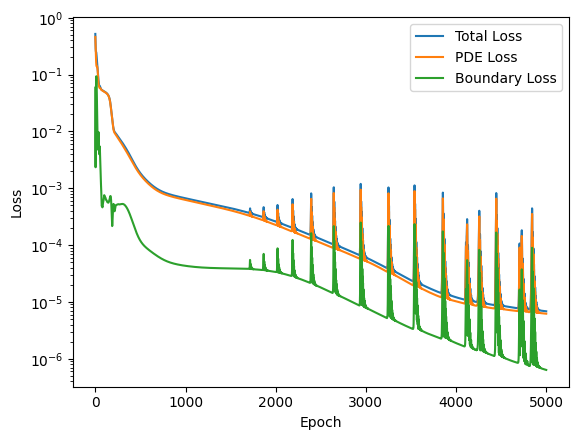

In [65]:
plt.figure()
plt.plot(total_loss_list, label='Total Loss')
plt.plot(loss_pde_list, label='PDE Loss')
plt.plot(loss_boundary_list, label='Boundary Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [66]:
def fdm(xmin, xmax, ymin, ymax, N_test):
  dx, dy = (xmax - xmin) / N_test, (ymax - ymin) / N_test

  x = np.linspace(xmin, xmax, N_test)
  y = np.linspace(ymin, ymax, N_test)
  X, Y = np.meshgrid(x, y)
  f = -np.sin(np.pi * X) * np.sin(np.pi * Y)

  u_initial = np.zeros((N_test, N_test))

  threshold = 1e-4
  error = 1

  while error > threshold:
    u = u_initial.copy()
    for i in range(1, N_test - 1):
      for j in range(1, N_test - 1):
        u[i, j] = 0.25 * (u_initial[i+1, j] + u_initial[i-1, j] + u_initial[i, j+1] + u_initial[i, j-1] - dx**2 * f[i, j])
    error = np.linalg.norm(u - u_initial)
    u_initial = u
  return u_initial, X, Y


In [67]:
# define exact solution
def exact_solution(points):
    x = tf.expand_dims(points[:,0], axis = 1)
    y = tf.expand_dims(points[:,1], axis = 1)
    solution =  (np.sin(np.pi * x) * np.sin(np.pi * y)) / (2 * np.pi**2)
    return solution.reshape((-1,))

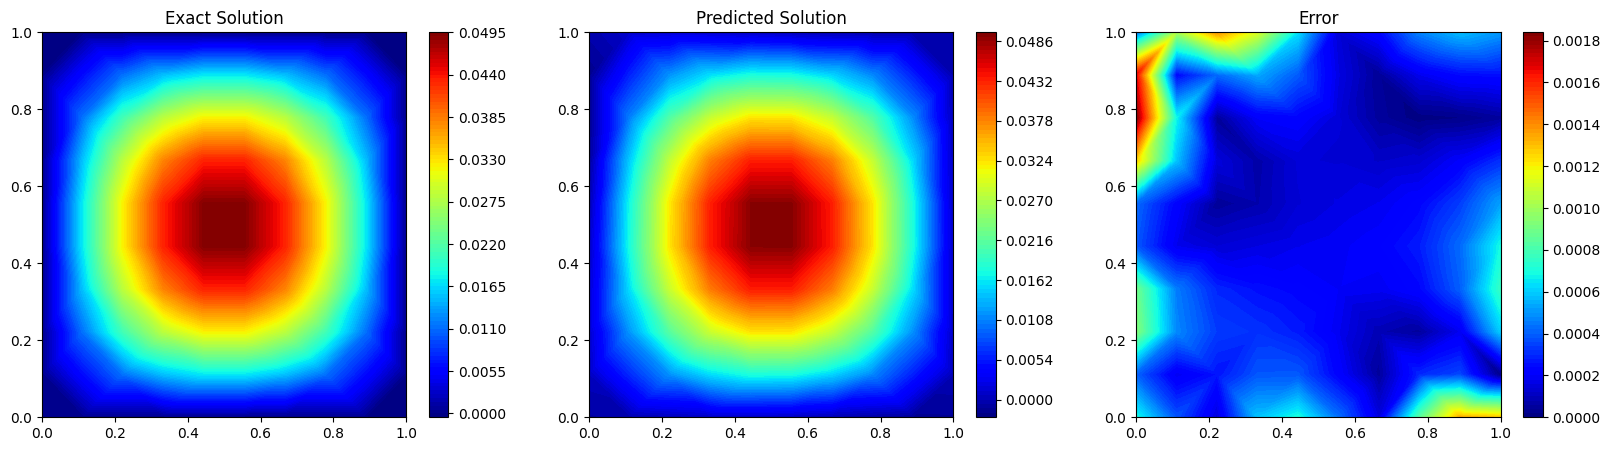

In [68]:
# plot the results
def generate_test_points(xmin, xmax, ymin, ymax, num_points=100):
    num = int(np.sqrt(num_points))
    x_test = np.linspace(xmin, xmax, num)
    y_test = np.linspace(ymin, ymax, num)
    X_test, Y_test = np.meshgrid(x_test, y_test)
    test_pt = np.column_stack((X_test.flatten(), Y_test.flatten()))
    return test_pt

test_pt = generate_test_points(xmin, xmax, ymin, ymax, N_test)
test_pt = tf.convert_to_tensor(test_pt, dtype = tf.float32)
u_pred = model(test_pt)
test_pt = test_pt.numpy()
u_pred = u_pred.numpy()

plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
plt.tricontourf(test_pt[:,0], test_pt[:,1], exact_solution(test_pt), cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('Exact Solution')

plt.subplot(1,3,2)
plt.tricontourf(test_pt[:,0], test_pt[:,1], u_pred[:,0], cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('Predicted Solution')

plt.subplot(1,3,3)
plt.tricontourf(test_pt[:,0], test_pt[:,1], abs(u_pred[:,0] - exact_solution(test_pt)), cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('Error')
plt.show()



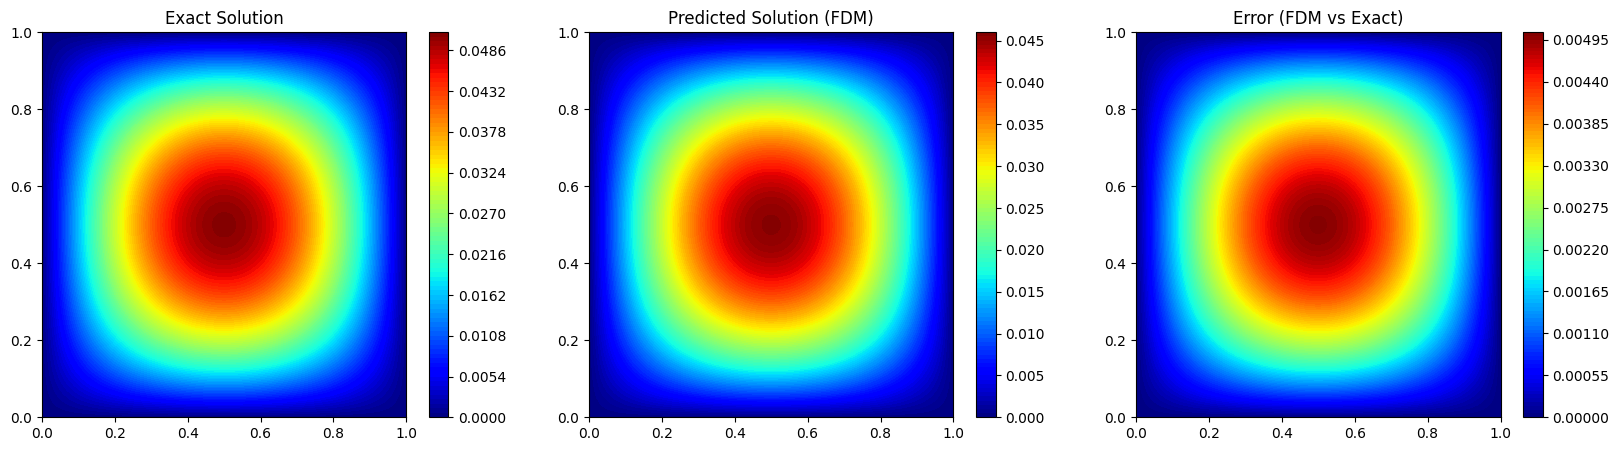

In [69]:
u_fdm, X, Y = fdm(xmin, xmax, ymin, ymax, N_test)
u_exact = (np.sin(np.pi * X) * np.sin(np.pi * Y)) / (2 * np.pi**2)
fdm_error = np.linalg.norm(u_fdm - u_exact) / np.linalg.norm(u_exact)

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already computed u_fdm, X, and Y

# Exact solution for comparison
u_exact = (np.sin(np.pi * X) * np.sin(np.pi * Y)) / (2 * np.pi**2)

# Calculate absolute error for visualization
fdm_error = np.abs(u_fdm - u_exact)

# Plotting
plt.figure(figsize=(20, 5))

# Exact solution plot
plt.subplot(1, 3, 1)
plt.contourf(X, Y, u_exact, cmap='jet', levels=100)
plt.colorbar()
plt.title('Exact Solution')

# Predicted solution plot (FDM solution)
plt.subplot(1, 3, 2)
plt.contourf(X, Y, u_fdm, cmap='jet', levels=100)
plt.colorbar()
plt.title('Predicted Solution (FDM)')

# Error plot
plt.subplot(1, 3, 3)
plt.contourf(X, Y, fdm_error, cmap='jet', levels=100)
plt.colorbar()
plt.title('Error (FDM vs Exact)')

plt.show()



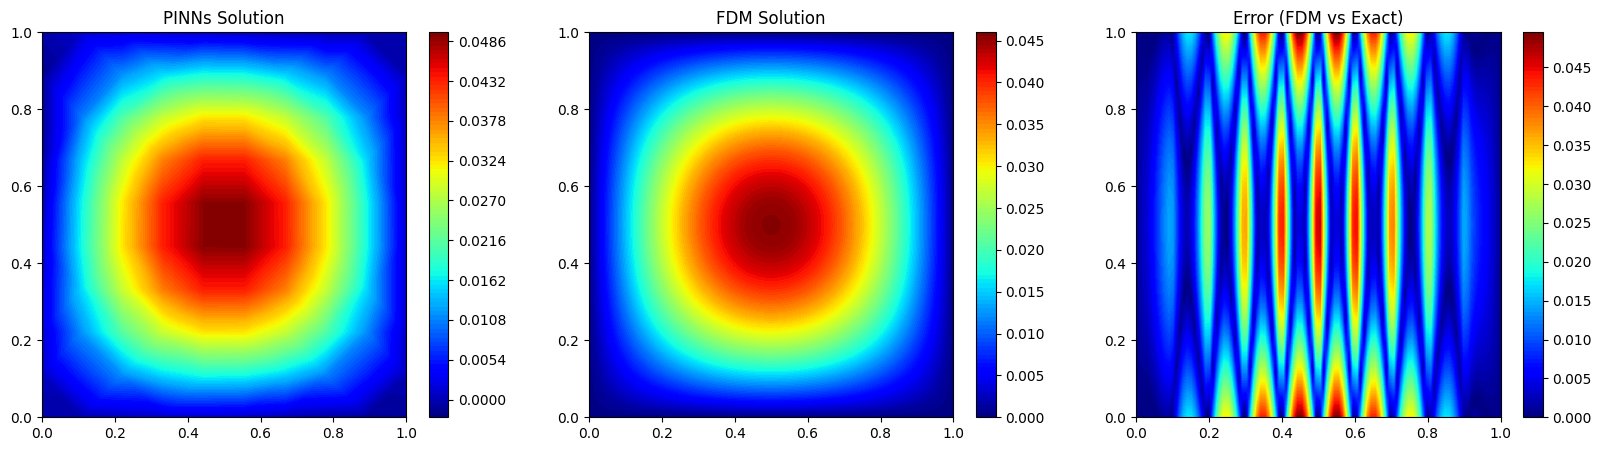

In [73]:
plt.figure(figsize=(20, 5))

# Exact solution plot
plt.subplot(1, 3, 1)
plt.tricontourf(test_pt[:,0], test_pt[:,1], u_pred[:,0], cmap = 'jet', levels = 100)
plt.colorbar()
plt.title('PINNs Solution')

# Predicted solution plot (FDM solution)
plt.subplot(1, 3, 2)
plt.contourf(X, Y, u_fdm, cmap='jet', levels=100)
plt.colorbar()
plt.title('FDM Solution')

# Error plot
plt.subplot(1, 3, 3)
plt.contourf(X, Y, abs(u_pred[:,0] - u_fdm), cmap='jet', levels=100)
plt.colorbar()
plt.title('Error (FDM vs Exact)')

plt.show()